In [25]:
import sys
from tqdm import tqdm
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.energy_data import *
from models.lstm import LSTM

In [26]:
timeseries = pd.read_csv('../data/data_preprocessed.csv')
timeseries = timeseries[['_value']]
train_dataset = EnergyDataset_2('../data/train.csv', window_size=8, predict_window=8)
test_dataset = EnergyDataset_2('../data/test.csv', window_size=8, predict_window=8)

train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, drop_last=True, shuffle=False)

X_train, y_train = train_dataset.return_X_y()
X_test, y_test = test_dataset.return_X_y()

In [28]:
model = LSTM(input_size=8, hidden_size=50, num_layers=1, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

In [29]:
n_epochs = 100

train_progress = []
test_progress = []

for i in range(n_epochs):
    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
            train_rmse = np.sqrt(loss_function(y_pred_train, y_train).item())
            test_rmse = np.sqrt(loss_function(y_pred_test, y_test).item())
            train_progress.append(train_rmse)
            test_progress.append(test_rmse)
            
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (i, train_rmse, test_rmse))


100%|██████████| 849/849 [00:02<00:00, 299.57it/s]


Epoch 0: train RMSE 0.1635, test RMSE 0.1354


100%|██████████| 849/849 [00:02<00:00, 333.23it/s]


Epoch 10: train RMSE 0.1574, test RMSE 0.1215


100%|██████████| 849/849 [00:02<00:00, 328.36it/s]


Epoch 20: train RMSE 0.1569, test RMSE 0.1249


100%|██████████| 849/849 [00:02<00:00, 335.57it/s]


Epoch 30: train RMSE 0.1585, test RMSE 0.1200


100%|██████████| 849/849 [00:02<00:00, 324.70it/s]


Epoch 40: train RMSE 0.1566, test RMSE 0.1228


100%|██████████| 849/849 [00:02<00:00, 334.82it/s]


Epoch 50: train RMSE 0.1564, test RMSE 0.1207


100%|██████████| 849/849 [00:02<00:00, 340.84it/s]


Epoch 60: train RMSE 0.1561, test RMSE 0.1239


100%|██████████| 849/849 [00:02<00:00, 348.73it/s]


Epoch 70: train RMSE 0.1557, test RMSE 0.1238


100%|██████████| 849/849 [00:02<00:00, 342.43it/s]


Epoch 80: train RMSE 0.1552, test RMSE 0.1239


100%|██████████| 849/849 [00:02<00:00, 355.15it/s]


Epoch 90: train RMSE 0.1550, test RMSE 0.1254


100%|██████████| 849/849 [00:02<00:00, 346.94it/s]


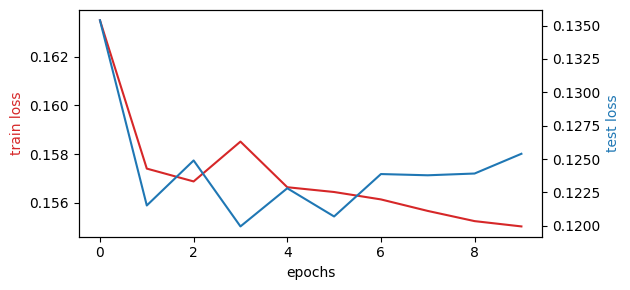

In [30]:
fig, ax1 = plt.subplots()
fig.set_figheight(3)

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('train loss', color=color)
ax1.plot(train_progress, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('test loss', color=color) 
ax2.plot(test_progress, color=color)

fig.tight_layout()
plt.show()

In [31]:
# define offset / window size for plotting
offset = 40

with torch.no_grad():
    # shift train predictions for plotting
    y_pred_train = model(X_train)[:,-1,:]
    y_pred_test = model(X_test)[:,-1,:]

print(y_pred_train.shape, y_pred_test.shape, y_pred_test.shape[0] + y_pred_train.shape[0])
y_pred = torch.cat([y_pred_train, y_pred_test], dim=0)
y_pred.shape

torch.Size([27190, 1]) torch.Size([6786, 1]) 33976


torch.Size([33976, 1])

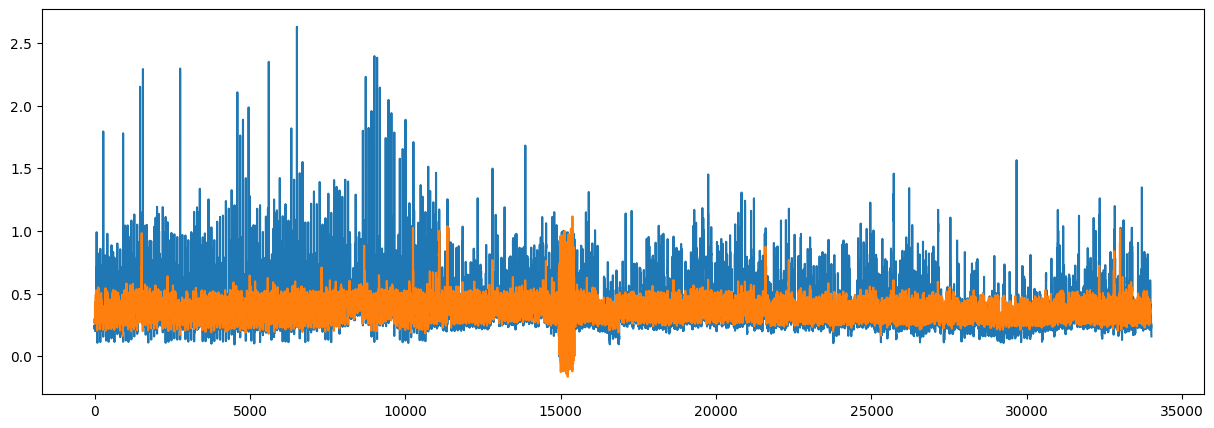

In [32]:
plt.figure(figsize=(15,5))
plt.plot(timeseries)
plt.plot(y_pred)

In [33]:
y_test = pd.read_csv('../data/test_data_new.csv')[['_value']]
y_train = pd.read_csv('../data/train.csv')[['_value']]

In [34]:
y_test = y_test[offset-1:].values.tolist()

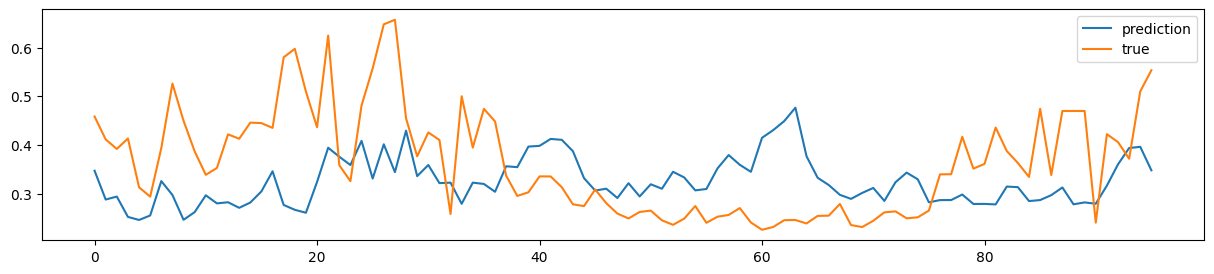

In [38]:
plt.figure(figsize=(15,3))
plt.plot(y_pred_test[:96], label='prediction')
plt.plot(y_test[:96], label='true')
plt.legend()
plt.show()

In [39]:
torch.save(model.state_dict(), '../saved_models/lstm_w96_entire_day.pt')